In order to map the pixel offset of the streak in the microscope image to the appropriate wavelengths, calibration measurements are conducted. For these, a $532\,\mathrm{nm}$ laser is focused on a coverslide, its reflection producing a spot. As in "actual" measurements, the diffraction grating in front of the camera sensor produces a no first-order image of the spot. As the wavelength is known and the first order isn't the streak we observe in "actual" measurements but a second spot. Due to the make of the diffraction grating used, this spot, in fact, appears much brigther than the zeroth order.

# Preparations

In [1]:
import os

In [2]:
import numpy as np
pi = np.pi

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "serif"


In [3]:
plt.style.use('dark_background')


In [62]:
from util import tdms, calibration_persistent_data_path

In [5]:
tdms_directories = [ "data/calibration/21-08-30/", "data/calibration/21-09-09/" ]
#tdms_directories = [ "data/calibration/21-09-09/" ]

tdms_files = [ "{p}/{f}".format( p=path, f=file ) for path in tdms_directories for file in os.listdir( path ) ]

tdms_descriptors = tdms.files_to_descriptors(tdms_files)

In [6]:
#tdms_files
#[ d.to_dict() for d in tdms_descriptors ]

In [7]:
videos = [ tdms.Video().load( d ) for d in tdms_descriptors ]

# Plot the Cumulative Video Data

In [8]:
import math

plot_cols = int(math.ceil(math.sqrt(float(len(videos)))))
plot_rows = int(math.ceil( len(videos)/plot_cols ))

print( "{c}x{r}".format(c=plot_cols, r=plot_rows) )

5x4


In [9]:
videos[0].data.shape

(1000, 1000, 1000)

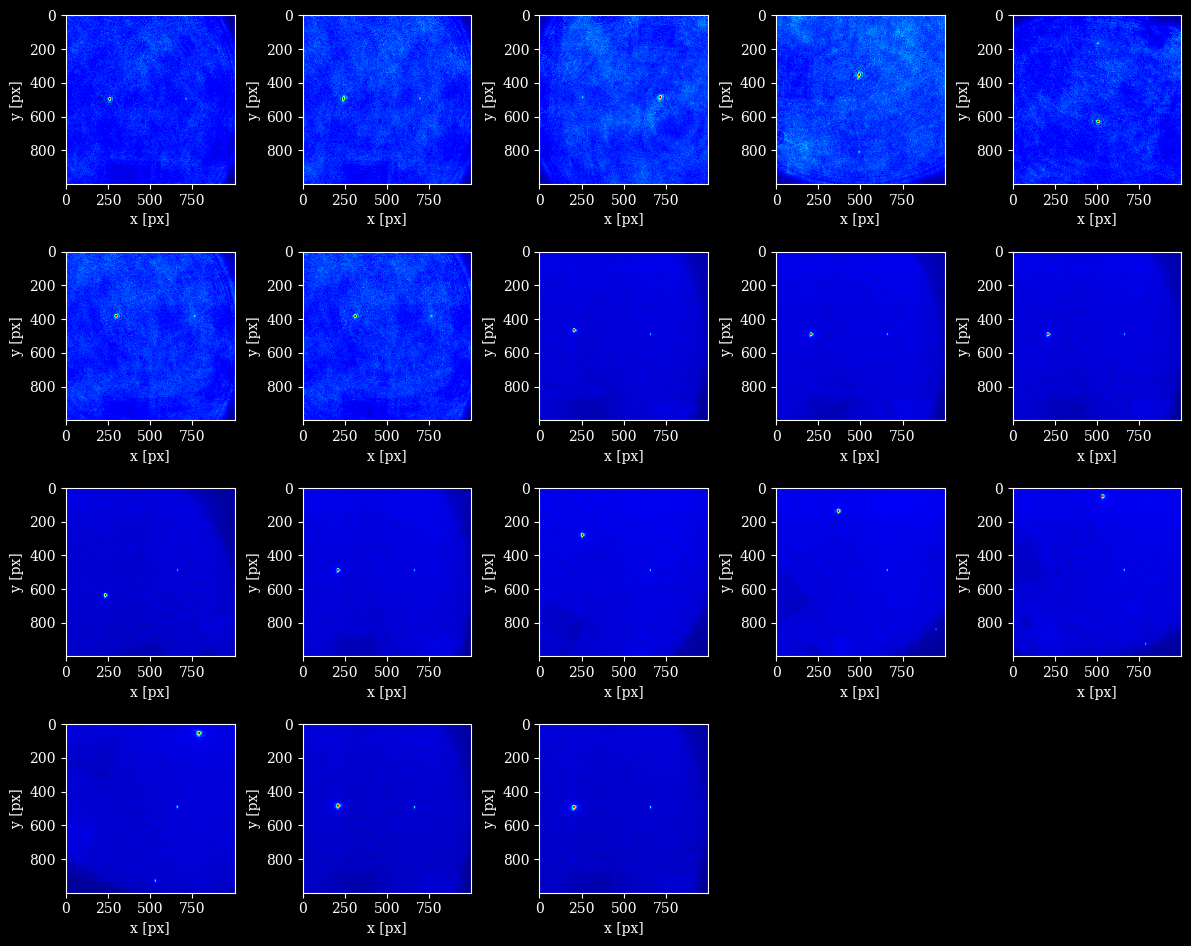

In [10]:
fig = plt.figure(figsize=(12,12*plot_rows/plot_cols), dpi=100)

axs = fig.add_gridspec(plot_rows, plot_cols)

for i in range(len(videos)):
    ax = fig.add_subplot(axs[ i//plot_cols , i%plot_cols ])
    ax.imshow(np.log( np.mean( videos[i].data, axis=0 ) ), 
              cmap='jet',
              interpolation='nearest')
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')

plt.tight_layout()
plt.show()

The spots are way easier to see in a logarithmic scale.

# Fitting
In the image, there should be two roughly Gaussian spots as well as some background intensity. The procedure is as follows:
 * find the position of the brightest spot. This will be the first order.
 * around this position, replace the data with the background intensity. Simply subtracting the fit Gaussian, won't work. as the residual might still be much brighter than the zeroth order spot will be. We know that the distance between these spots is in the hundreds of pixels, so as long as the area in which we obliterate our signal smaller than that, we should be fine.
 * find the next-brightest spot. That'll be the zeroth order.
 * compute distance and angle. The angle shoulkd corresponds to how far the diffraction grating was screwed into the camera's front plate and should hence correspond to the distance of the grating from the sensor. The relationship between the distance and the angle should be linear.
 * manually adjust the angle for any full rotations.

In [11]:
from scipy.optimize import curve_fit

## Define a Fitting Function

In [12]:
def gaussian( x, y, a, x0, y0, sigma, offset ):
    res = offset + a*np.exp( -0.5 * ( ((x-x0)**2 + (y-y0)**2))/(sigma**2) )
    return res.ravel()

In [13]:
def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
        arr += gaussian(x,y, *args[i*5:i*5+5])
    return arr

## Initial Definitions

In [14]:
# number of spots to try and find
N = 2

In [15]:
spot_params = np.zeros( (len(videos), N, 5) )

## Perform The Fits

In [16]:
for VIDEO, INDEX in zip(videos,range(len(videos))):
    x, y = np.linspace(0, VIDEO.width-1, VIDEO.width), np.linspace(0, VIDEO.height-1, VIDEO.height)
    X, Y = np.meshgrid(x, y)

    Z = np.mean( VIDEO.data, axis=0)

    #spot_params = np.zeros( (N,5) )

    for k in range(N):
        guess_background = np.mean( Z )
        guess_amp = np.max( Z ) - guess_background
        argmax = np.argmax( Z )
        guess_x0 = argmax % VIDEO.height
        guess_y0 = argmax // VIDEO.height
        guess_sigma = 5.0
        # A list of parameters for the Gaussian: a, x0, y0, sigma, offset
        guess_params = [ ( guess_amp , guess_x0, guess_y0, guess_sigma, guess_background ) ]

        p0 = [ p for prms in guess_params for p in prms ]

        # We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
        xdata = np.vstack((X.ravel(), Y.ravel()))
        # Do the fit, using our custom _gaussian function which understands our
        # flattened (ravelled) ordering of the data points.
        popt, pcov = curve_fit(_gaussian, xdata, Z.ravel(), p0)
        fit = np.zeros(Z.shape)
        #for i in range(len(popt)//5):
        fit += gaussian(X, Y, *popt).reshape(fit.shape)

        spot_params[INDEX,k] = popt

        zfilter = gaussian(X, Y, 1.0, popt[1], popt[2], 10*popt[3], 0.0).reshape(fit.shape)
        Z *= 1-zfilter
        Z += zfilter*popt[4]

In [17]:
#spot_params

In [18]:
displacements = spot_params[:,0,1:3]-spot_params[:,1,1:3]

## Plot the Results

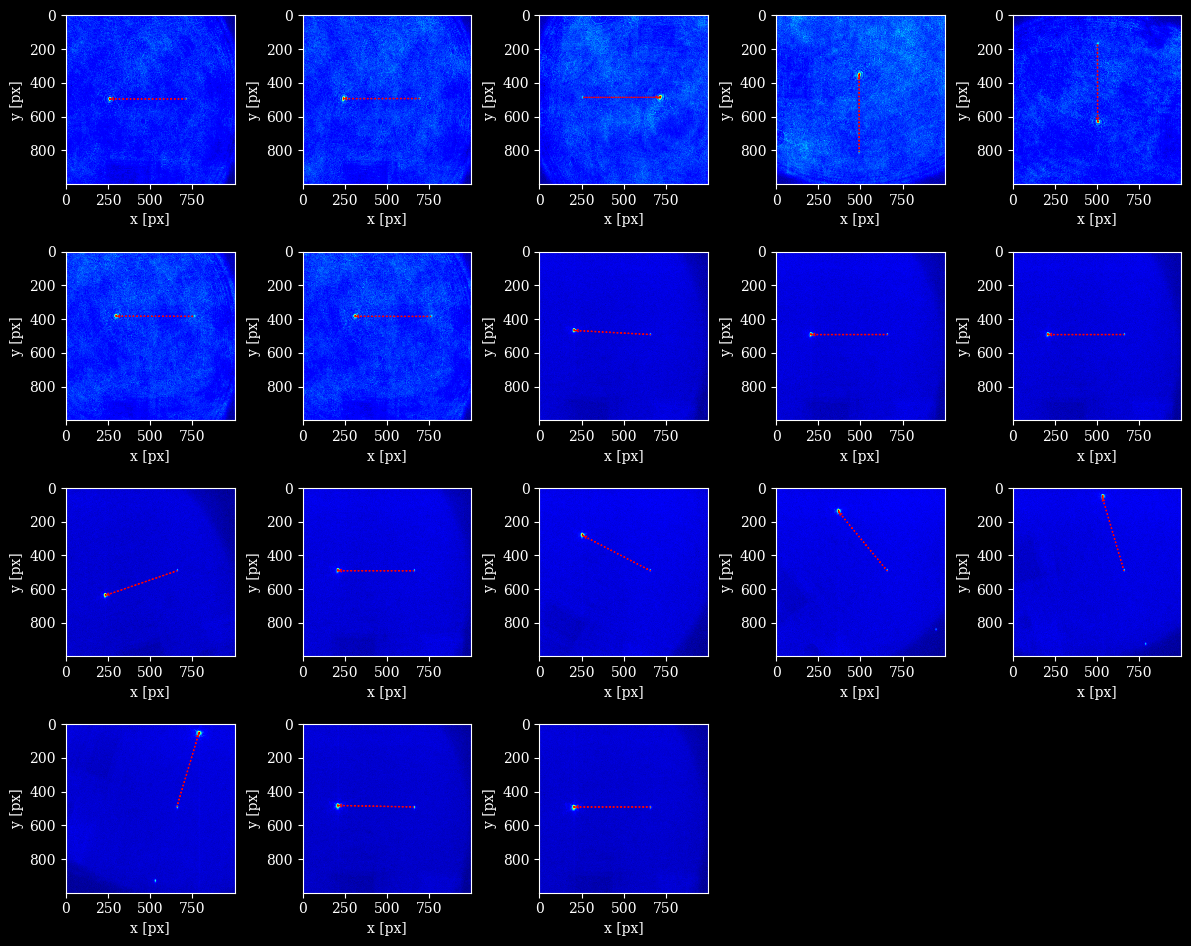

In [19]:
fig = plt.figure(figsize=(12,12*plot_rows/plot_cols), dpi=100)

axs = fig.add_gridspec(plot_rows, plot_cols)

for i in range(len(videos)):
    ax = fig.add_subplot(axs[ i//plot_cols , i%plot_cols ])
    ax.imshow(np.log( np.mean( videos[i].data, axis=0 ) ), 
              cmap='jet',
              interpolation='nearest')
    
    ax.arrow( spot_params[i,1,1], spot_params[i,1,2], 
              displacements[i,0], displacements[i,1],
              length_includes_head=True, color='red', head_width=15, ls=':')
    
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')

    
    
plt.tight_layout()
plt.show()

# Compute Angles and Distances

In [20]:
distances = np.sqrt( np.square(displacements[:,0]) + np.square(displacements[:,1]) )
angles = np.arctan2( displacements[:,0], displacements[:,1] )/pi*180.0-90.0

# Correct for possible Full Rotations

## Plot

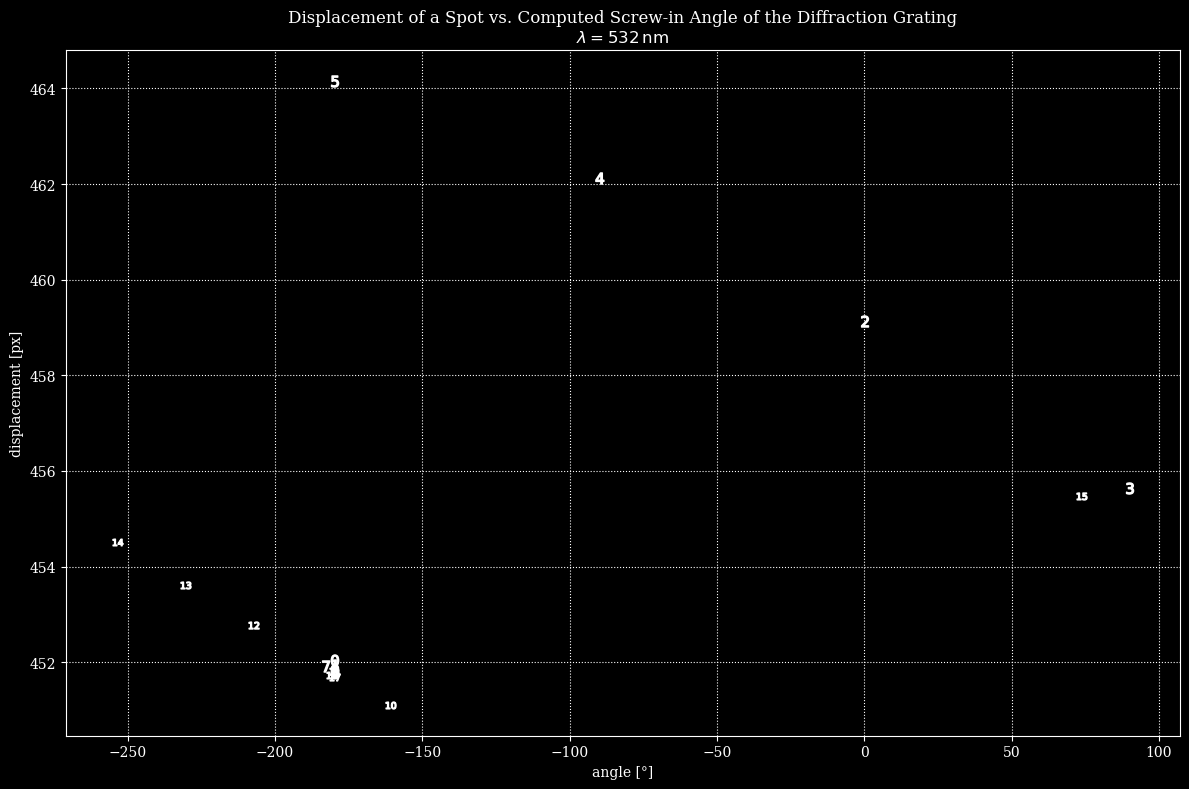

In [21]:
fig = plt.figure(figsize=(12,8), dpi=100)

axs = fig.add_gridspec(1, 1)

ax = fig.add_subplot(axs[ 0 , 0 ])

for a,d,n in zip(angles, distances, range(len(angles))):
    ax.scatter( a, d, s=64, c='w', marker="$N$".replace("N", "{N}".format(N=n) ) )

ax.set_xlabel('angle [°]')
ax.set_ylabel('displacement [px]')
ax.set_title("Displacement of a Spot vs. Computed Screw-in Angle of the Diffraction Grating\n$\lambda = 532\,\mathrm{nm}$")

ax.grid( ls=':' )

plt.tight_layout()
plt.show()

## Manual Adjustment

In [49]:
full_rotations = np.zeros( len(angles) )

full_rotations += 1 
for i in [ 5, 4, 2, 3, 15 ]:
    full_rotations[i] -= 1

In [50]:
adjusted_angles = angles + full_rotations*360.0

## Plot Again

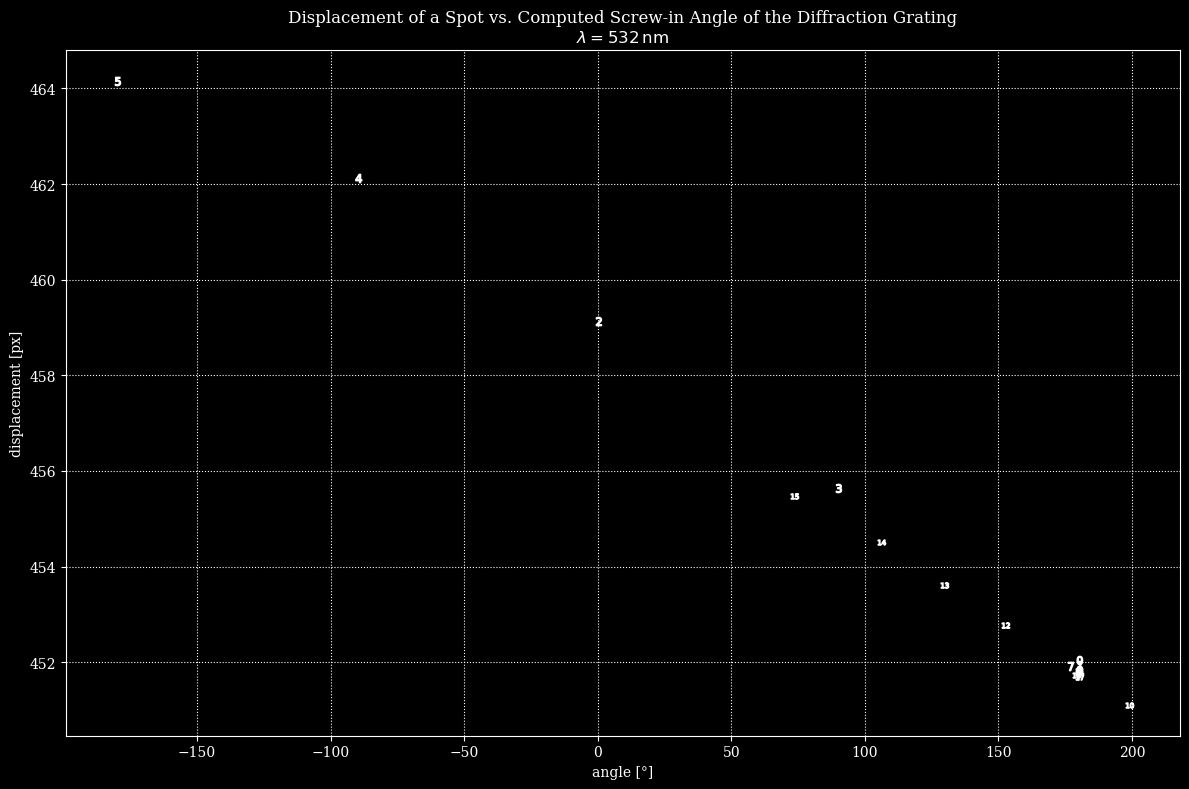

In [51]:
fig = plt.figure(figsize=(12,8), dpi=100)

axs = fig.add_gridspec(1, 1)

ax = fig.add_subplot(axs[ 0 , 0 ])

for a,d,n in zip(adjusted_angles, distances, range(len(angles))):
    ax.scatter( a, d, c='w', marker="$N$".replace("N", "{N}".format(N=n) ) )

ax.set_xlabel('angle [°]')
ax.set_ylabel('displacement [px]')
ax.set_title("Displacement of a Spot vs. Computed Screw-in Angle of the Diffraction Grating\n$\lambda = 532\,\mathrm{nm}$")

ax.grid( ls=':' )

plt.tight_layout()
plt.show()

# Linear Fit

In [52]:
linear_model=np.polyfit(adjusted_angles,distances,1)
linear_model_fn=np.poly1d(linear_model)

## Error Estimation

In [53]:
stddev = math.sqrt( np.mean( np.square( distances-linear_model_fn(adjusted_angles) ) ) )

## Plot

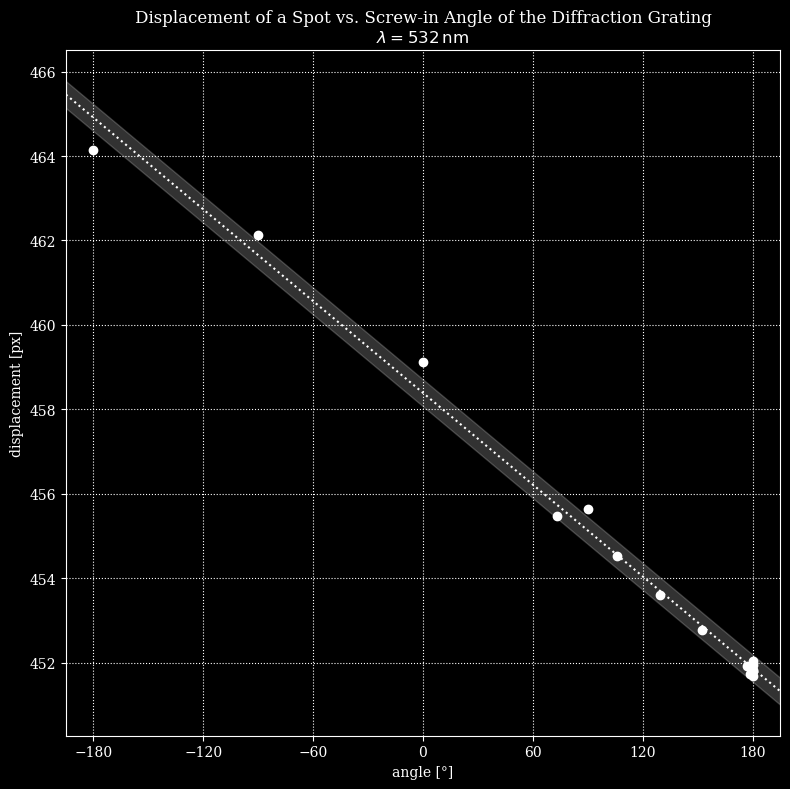

In [54]:
fig = plt.figure(figsize=(8,8), dpi=100)
#fig.patch.set_facecolor('white')

x_range = [-195,195]

axs = fig.add_gridspec(1, 1)

ax = fig.add_subplot(axs[ 0 , 0 ])

#ax.plot( angles, distances, c='w', ls=':' )
ax.fill_between( x_range, 
                 linear_model_fn(x_range)+stddev, 
                 linear_model_fn(x_range)-stddev, 
                 alpha=0.2, color='w' )
ax.plot( x_range, linear_model_fn(x_range), c='w', ls=':' )
ax.scatter( adjusted_angles, distances, c='w' )

ax.set_xlabel('angle [°]')
ax.set_ylabel('displacement [px]')
ax.set_title("Displacement of a Spot vs. Screw-in Angle of the Diffraction Grating\n$\lambda = 532\,\mathrm{nm}$")

ax.set_xticks( np.arange( -180, 270, 60 ) )
ax.set_xlim( x_range )

ax.grid( ls=':' )

plt.tight_layout()
plt.show()

# Export

In [55]:
b = linear_model_fn(0)
a = linear_model_fn(1) - b

In [59]:
calibration = { 'slope':a, 'intercept':b, 'error':stddev }
calibration

{'slope': -0.036223826343871224,
 'intercept': 458.39186816066996,
 'error': 0.3193871100028442}

In [60]:
import pickle

In [65]:
filename = "{d}/calibration.pickle".format( d=calibration_persistent_data_path )
exportfile = open( filename, 'wb' )
exportfile.write( pickle.dumps( calibration ) )
exportfile.close()